# Artificial Intelligence for Healthcare HS 2024

## Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning

---
Javier Montoya: javier.montoya at hslu.ch

**About Retinal OCT**

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time [Swanson and Fujimoto, 2017].

OCT imaging is now a standard of care for guiding the diagnosis and treatment of some of the leading causes of blindness worldwide: age-related macular degeneration (AMD) and diabetic macular edema (DME) [Kermany et al. 2018]

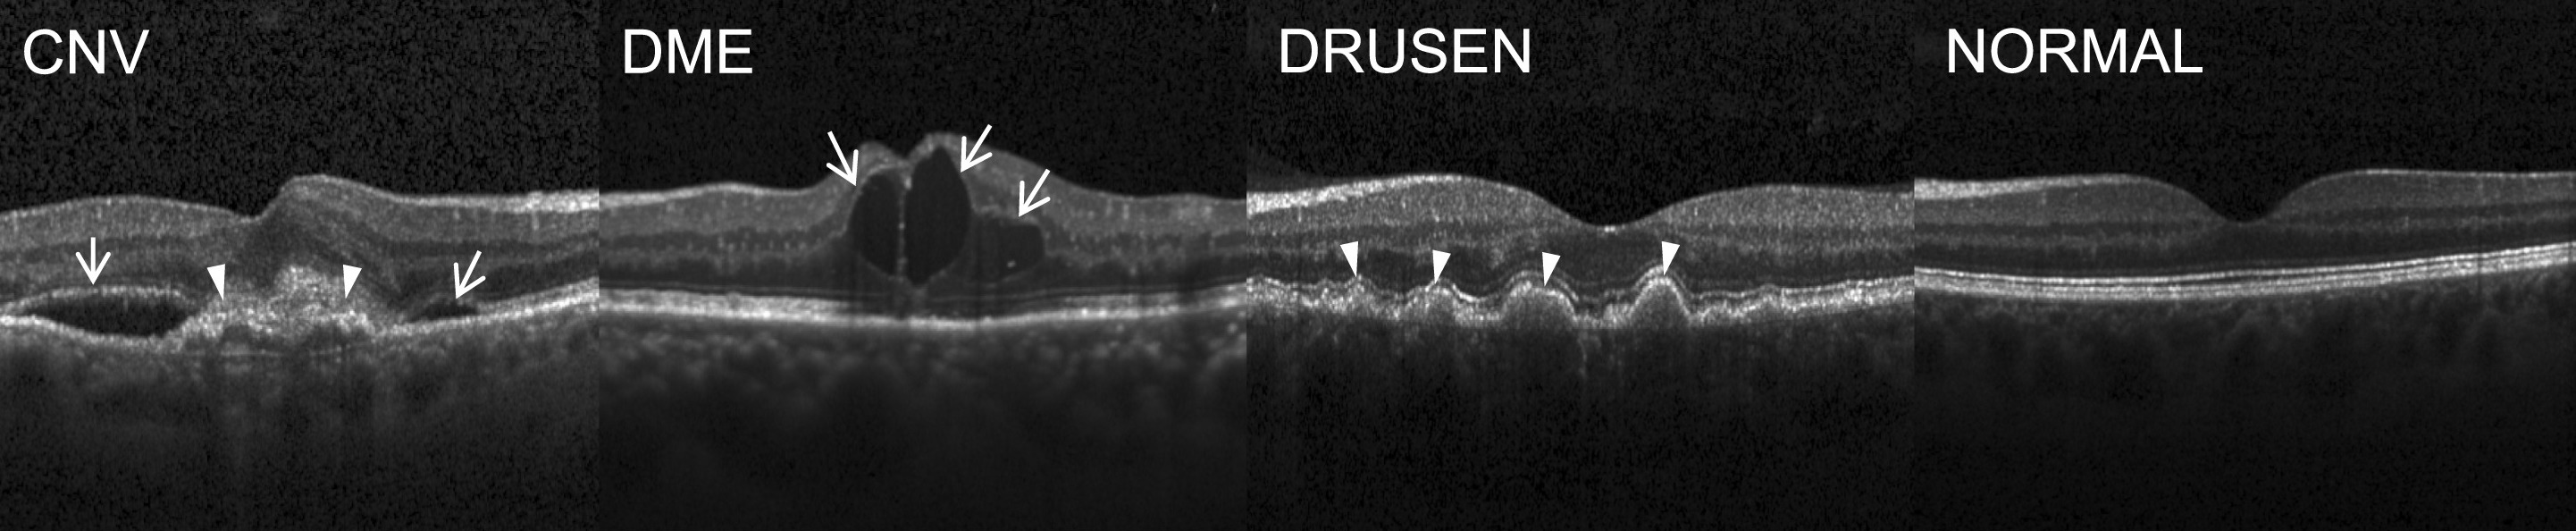


(A) (Far left) choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

The exercise is about train a supervised learning algorithm (CNN) for the classification of Retinal OCT scans based on image features extracted from pre-trained CNN models. Along this project, there are different subtasks to be done. Each of these subtasks are going to be explained on detail below. Your task is to fill this jupyter notebook.

## Tasks
1. **Transfer Learning**: consider using different pre-trained CNN architectures for extracting the image features. For a complete overview of different pre-trained architectures have a look at [CNN-zoo](https://pytorch.org/vision/stable/models.html). Repeat the training and evaluating/fine-tuning process.
2. **Experimental evaluation**: use different CNN architectures and compare their accuracies. Also fine-tune them properly and evaluate their results. Which one performed best? What is the intuition behind? Some examples of CNN architecture include: VGG-16, ResNet34. Also, what happens if your train your models from scratch, instead of finetuning them?
3. Summarize what are the strenghts and weaknesses of each of the implemented models.Which architectures help the most and why?
4. Given the fact that the dataset is skewed (more samples from one class than the other), how can you tackle the problem of class imbalance? Proof that your idea works by implementing it.
5. Create an Fusion Model, in which you take 2 pre-trained CNNs, and fuse them as a new EnsembleModel. You can merge the before-last features from the classifier. Now train this new model and see the improvements?
6. One key aspect when dealing with AI models is the interpretability of their results. As such, investigate: ($i$) how the trained filters look like (visualise the learned weights),  ($ii$) use class activation maps (CAMs) to visualise which parts of the image are used for retina-diseases  classification? [BONUS].
7. Instead of fine-tuning your CNN models, extract feature vectors from your pre-trained CNN models by feeding them with the images and feed-forwarding the images through the model. Next, we collect feature vectors from the FC layers of the model. The collection of those vetors will represent the new dataset, over which we will train different ML classifiers (e.g. Random Forest, XGBoost ). Compare their classification results and also against the results obtained from the transfer-learning approach [BONUS].

**CNN description:** In the Figure below, you find different CNN architectures pre-trained on the Imagenet dataset. Their top-1 accuraries are visualied on the y-axis, whilst their number of parameters in the x-axis. Most of these pre-trained models are available at pytorch's [CNN-zoo](https://pytorch.org/vision/stable/models.html).

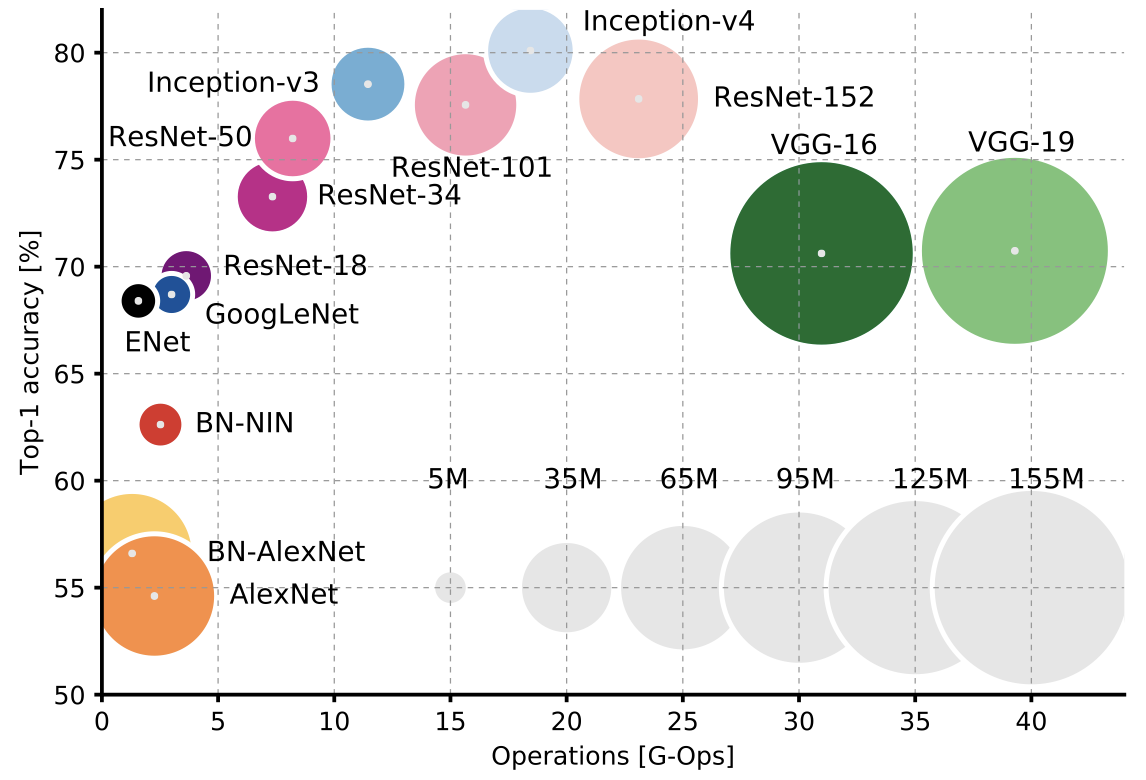

## Dataset Overview

* The training dataset comprises $108,312$ images ($37,206$ with choroidal neovascularization, $11,349$ with diabetic macular edema, $8,617$ with drusen, and $51,140$ normal) from $4,686$ patients.
* The training set is further splited into two subsets, namely, a training and a validation dataset by using 80% for training and 20% for validation.
* The test dataset consists of $1,000$ images ($250$ from each category) from $633$ patients.

## Importing Libraries

In [1]:
!pip install scikit-plot

In [3]:
import time
import os
import copy

import numpy as np
import PIL as PIL
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from google.colab import drive  # Import the drive module from google.colab for interacting with Google Drive in Colab

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils import data
from torch.utils.data import Subset
from torchvision.io import read_image
from torch.utils.data import DataLoader

from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from skimage import io, color

#from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
#from pytorch_grad_cam.utils.image import show_cam_on_image

## Global Settings

In [4]:
DATA_DIR = 'data/OCT2024'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

CATEGORIES = ['train','val','test']
BATCH_SIZE = 128
NUM_WORKERS = 8

# Hyperparameters
LEARNING_RATE = 0.0001
NUM_EPOCHS = 5

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Obtaining  Dataset

In [5]:
# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%ls '/content/gdrive/My Drive/teaching/jupyter/hslu/health/HS2024/shared/OCT2024.zip'

'/content/gdrive/My Drive/teaching/jupyter/hslu/health/HS2024/shared/OCT2024.zip'


In [9]:
!mkdir -p ./data

In [10]:
!unzip '/content/gdrive/My Drive/teaching/jupyter/hslu/health/HS2024/shared/OCT2024.zip' -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-4136221-5.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-4921376-46.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-3929912-13.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-9290514-37.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-8651047-3.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-9032419-4.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-6544965-8.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-8923368-16.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-5487005-8.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-5677894-1.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-8932568-5.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-7588242-3.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-2362653-5.jpeg  
  inflating: ./data/OCT2024/train/NORMAL/NORMAL-6418744-7.jpeg  
  inflating: ./data/OCT2024/train/N

### Preparing  Dataset

In [11]:
# You should create a composite of transformations that are going to be applied on the training/test images.
# As the resolution of the images varies, all images have to be resized to 224x224 pixels. Next,
# you should normalise the image pixels to the [0,1] and, afterwards, normalise the data to
# zero-mean and standard-deviation using the pre-defined values given by (mean_values, std_values).
# Hint: Have a look at transforms.Compose(), transforms.ToTensor() and related functions.

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]
RSZE_SIZE = 384

# data augmentation
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(RSZE_SIZE),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # [0,255] -> [0,1]
        transforms.Normalize(mean_values, std_values) # Z-normalisation
    ]),
    'val': transforms.Compose([
        transforms.Resize(RSZE_SIZE),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # [0,225] -> [0,1]
        transforms.Normalize(mean_values, std_values) # Z-normalisation
    ]),
    'test': transforms.Compose([
        transforms.Resize(RSZE_SIZE),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # [0,225] -> [0,1]
        transforms.Normalize(mean_values, std_values) # Z-normalisation
    ]),
}

Each dataset (train, val, test dataset) is constructed using the *ImageFolder* class from the *torchvision.datasets* module. This class enables loading image data from directories where images are organized into subdirectories, with each subdirectory representing a different class.

In [13]:
# Datasets from each folder
image_datasets = {
    'train': datasets.ImageFolder(root=TRAIN_DIR, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=VALID_DIR, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=TEST_DIR, transform=image_transforms['test']),
    }

Create data loaders for the training, validation, and test datasets, which were previously prepared using the ImageFolder class. Data loaders are essential for efficiently loading and batching data during the training, validation, and testing phases of machine learning models. For that we will use the *DataLoader* class from the *torchvision.datasets* module.

In [14]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(dataset=image_datasets['train'], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True),
    'val': DataLoader(dataset=image_datasets['val'], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
    'test': DataLoader(dataset=image_datasets['test'], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS),
}

Determine the sizes of the different datasets, namely the training, validation, and test datasets. The sizes of each dataset are calculated using the *len()* function of the corresponding *image_datasets*. The sizes are then stored in a dictionary named dataset_sizes, where the keys represent the dataset types ('train', 'val', 'test') and the values represent the respective sizes of each dataset.

In [15]:
dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}

In [16]:
class_names = image_datasets['train'].classes
NUM_CLASSES = len(class_names)
print(class_names)
print(NUM_CLASSES)

['CNV', 'DME', 'DRUSEN', 'NORMAL']
4


In [17]:
print(image_datasets['test'].classes)

['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [18]:
for cate in CATEGORIES:
  print('Dataset split \'{}\' number of images: {}'.format(cate, dataset_sizes[cate]))

Dataset split 'train' number of images: 83484
Dataset split 'val' number of images: 32
Dataset split 'test' number of images: 968


In [24]:
def tensor2image(image, mean_values=[0.485, 0.456, 0.406], std_values=[0.229, 0.224, 0.225]):
    """Imshow for Tensor."""

    # Set the color channel as the third dimension
    image = image.cpu().numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array(mean_values)
    std = np.array(std_values)
    image = std * image + mean  # unormalise image

    # Clip the image pixel values to [0, 1]
    image = np.clip(image, 0, 1)

    return image

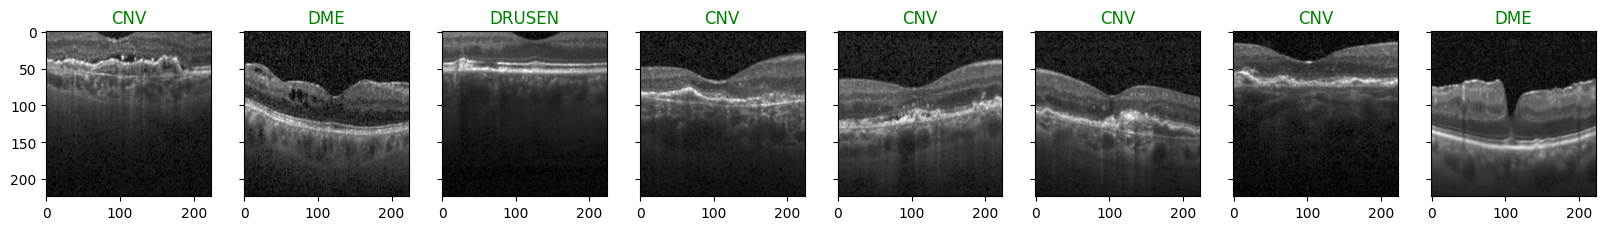

In [25]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Visualize some training images
n_images = 8

fig, axes = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = inputs[:n_images]

for ii in range(n_images):
    curr_img = tensor2image(orig_images[ii])

    axes[ii].imshow(curr_img)
    axes[ii].set_title('{}'.format(class_names[classes[ii]]), color='green')


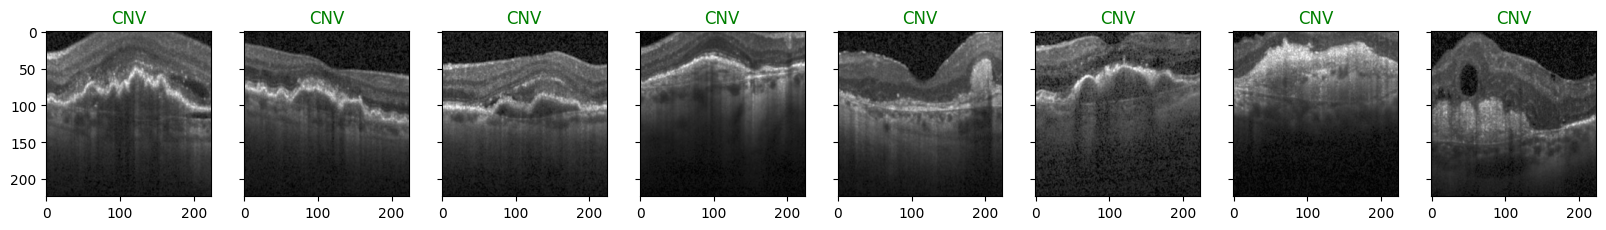

In [27]:
# Get a batch of validation data
inputs, classes = next(iter(dataloaders['val']))

# Visualize some validation images
n_images = 8

fig, axes = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = inputs[:n_images]

for ii in range(n_images):

    curr_img = tensor2image(orig_images[ii])

    axes[ii].imshow(curr_img)
    axes[ii].set_title('{}'.format(class_names[classes[ii]]), color='green')


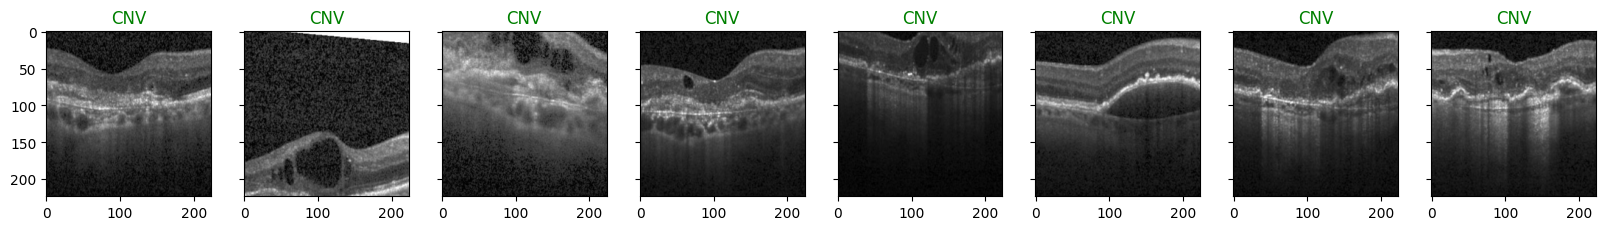

In [28]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Visualize some test images
n_images = 8

fig, axes = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = inputs[:n_images]

for ii in range(n_images):

    curr_img = tensor2image(orig_images[ii])

    axes[ii].imshow(curr_img)
    axes[ii].set_title('{}'.format(class_names[classes[ii]]), color='green')


In [43]:
def get_class_distribution(directory):
    """
    Retrieves the distribution of training samples across different classes in the specified directory.

    This function counts the number of training samples for each class in the given directory and returns
    a DataFrame containing the class distribution information.

    Args:
        directory (str): The path to the directory containing subdirectories for each class.

    Returns:
        pandas.DataFrame: A DataFrame containing the distribution of training samples across different classes.
    """

    # Define a dictionary to store the class distribution information, where keys represent class names
    class_distribution = {
        # # For each class, count the number of files (samples) in the corresponding directory
        'CNV': [len([filename for filename in os.listdir(directory + '/CNV')])],
        'DME': [len([filename for filename in os.listdir(directory + '/DME')])],
        'DRUSEN': [len([filename for filename in os.listdir(directory + '/DRUSEN')])],
        'NORMAL': [len([filename for filename in os.listdir(directory + '/NORMAL')])]
    }
    df_class = pd.DataFrame.from_dict(class_distribution) # create dataframe from dictionary
    return df_class

In [40]:
directory = TRAIN_DIR
class_distribution = {
    # # For each class, count the number of files (samples) in the corresponding directory
    'CNV': [len([filename for filename in os.listdir(directory + '/CNV')])],
    'DME': [len([filename for filename in os.listdir(directory + '/DME')])],
    'DRUSEN': [len([filename for filename in os.listdir(directory + '/DRUSEN')])],
    'NORMAL': [len([filename for filename in os.listdir(directory + '/NORMAL')])]
}

In [41]:
class_distribution

{'CNV': [37205], 'DME': [11348], 'DRUSEN': [8616], 'NORMAL': [26315]}

In [42]:
pd.DataFrame.from_dict(class_distribution)

CNV    DME  DRUSEN  NORMAL
0  37205  11348    8616   26315

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution(df_samplesize, category):
    """
    Plot the class distribution of a dataset.

    Args:
        df_samplesize (pd.DataFrame): DataFrame containing the sample sizes of different classes.
        category (str): Category of the dataset (e.g., 'Training', 'Validation', 'Test').

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_samplesize, palette='Pastel1')
    plt.title('{} Class Distribution'.format(category), fontsize=20)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Sample Size', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [45]:
# Compute the class distribution of the training dataset
train_samplesize = get_class_distribution(TRAIN_DIR)
print(train_samplesize)

     CNV    DME  DRUSEN  NORMAL
0  37205  11348    8616   26315


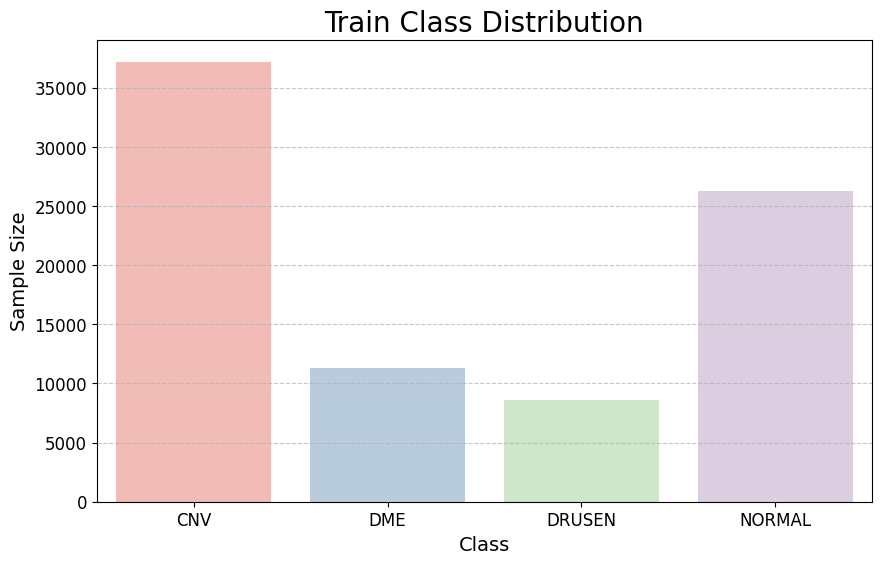

In [46]:
# Plot the class distribution of the training dataset
plot_class_distribution(train_samplesize, 'Train')

In [ ]:
# Compute the class distribution of the validation dataset
valid_samplesize = ...
print(valid_samplesize)

   CNV  DME  DRUSEN  NORMAL
0    8    8       8       8


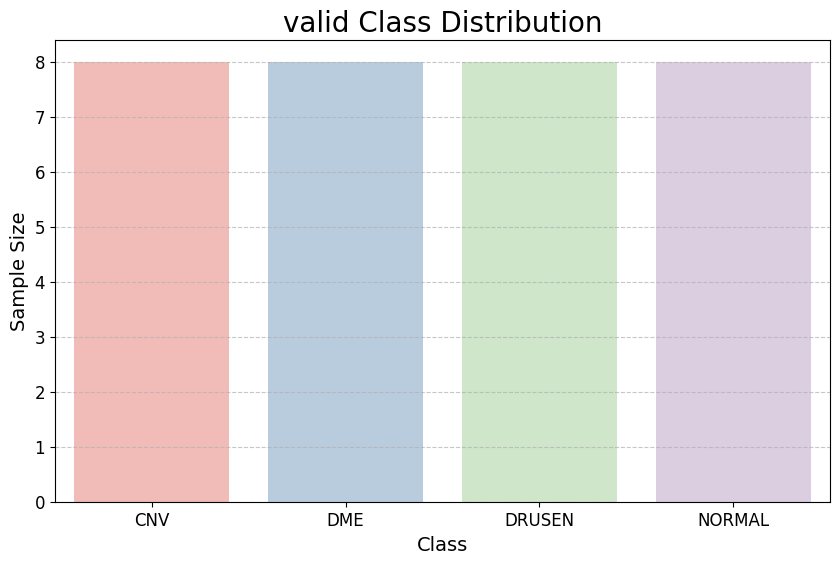

In [ ]:
# Plot the class distribution of the validation dataset
plot_class_distribution(valid_samplesize, 'valid')

In [ ]:
# Compute the class distribution of the test dataset
test_samplesize =  ...
print(test_samplesize)

   CNV  DME  DRUSEN  NORMAL
0  242  242     242     242


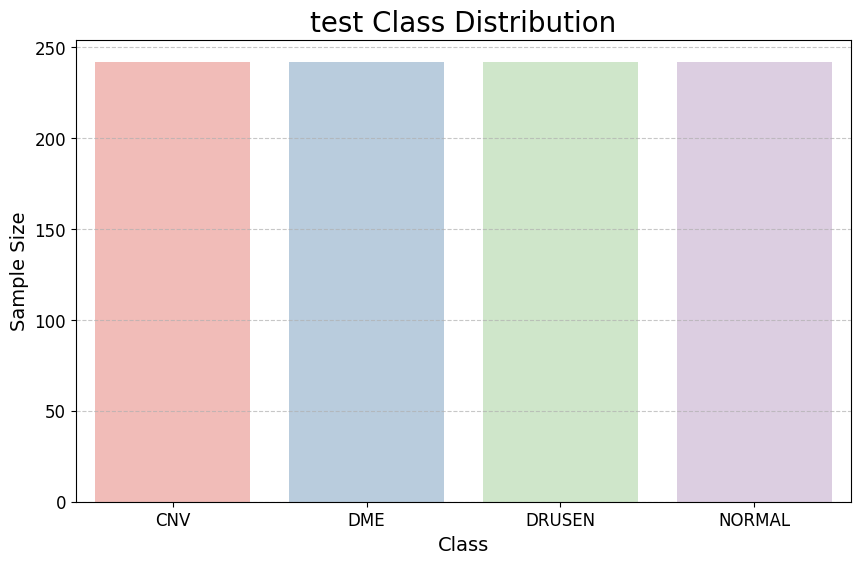

In [ ]:
# Plot the class distribution of the test dataset
plot_class_distribution(test_samplesize, 'test')

In [ ]:
from collections import Counter

def count_training_samples(directory):
    """
    Counts the number of training samples for each class in the specified directory.

    This function iterates through the subdirectories corresponding to each class in the given directory,
    counts the number of files (training samples) in each subdirectory, and returns a dictionary containing
    the counts for each class.

    Args:
        directory (str): The path to the directory containing subdirectories for each class.

    Returns:
        dict: A dictionary where keys are class names and values are the corresponding counts of training samples.
    """

    classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

    # Initialize a Counter object to store the counts of samples for each class
    class_counts = Counter()

    # Iterate through the list of class names
    for cls in classes:

        # Count the number of files (samples) in the directory corresponding to the current class
        # and store the count in the class_counts dictionary
        class_counts[cls] = len([os.path.join(directory+'/'+cls, filename)
                                 for filename in os.listdir(directory+'/'+cls)])

    # Return the class_counts dictionary containing the counts of samples for each class
    return class_counts

In [ ]:
# Use the count_training_samples to create a dictionary of the per-class amount of smaples.
class_counts = count_training_samples(TRAIN_DIR)
print("Class Counts:", class_counts)

Class Counts: Counter({'CNV': 37205, 'NORMAL': 26315, 'DME': 11348, 'DRUSEN': 8616})


In [ ]:
def get_class_weights(class_counts):
    """
    Computes class weights based on the counts of training samples for each class.

    This function calculates class weights to handle class imbalance by inversely scaling the frequency of each class.

    Args:
        class_counts (dict): A dictionary where keys are class names and values are the corresponding counts of training samples.

    Returns:
        torch.Tensor: A tensor containing the computed class weights.
    """
    # Calculate the total number of samples by summing the counts of samples for all classes on 'class_counts'.
    total_samples = ...

    # Initialize a tensor to store the class weights, with the length equal to the number of classes
    class_weights = ...

    # Iterate through the class counts dictionary to compute the class weights
    for i, (_, count) in enumerate(class_counts.items()):
        # Compute the weight for the current class by inversely scaling the frequency
        class_weights[i] = ...

    # Return the computed class weights as a tensor
    return class_weights

In [ ]:
# Using the get_class_weights compute the class weights
class_weights = ...
print(class_weights)

tensor([0.5610, 1.8392, 2.4224, 0.7931])


## Model Definition

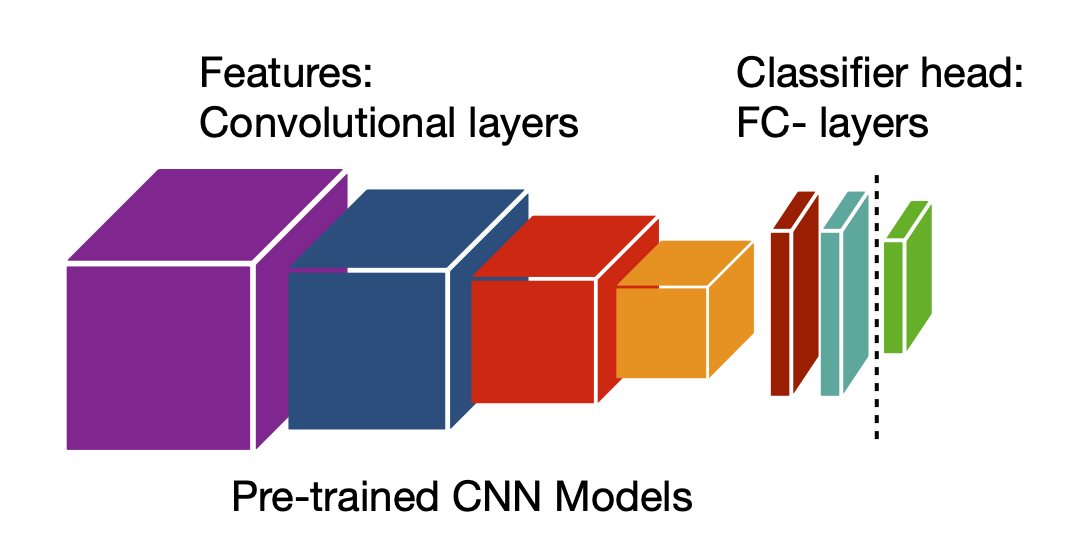

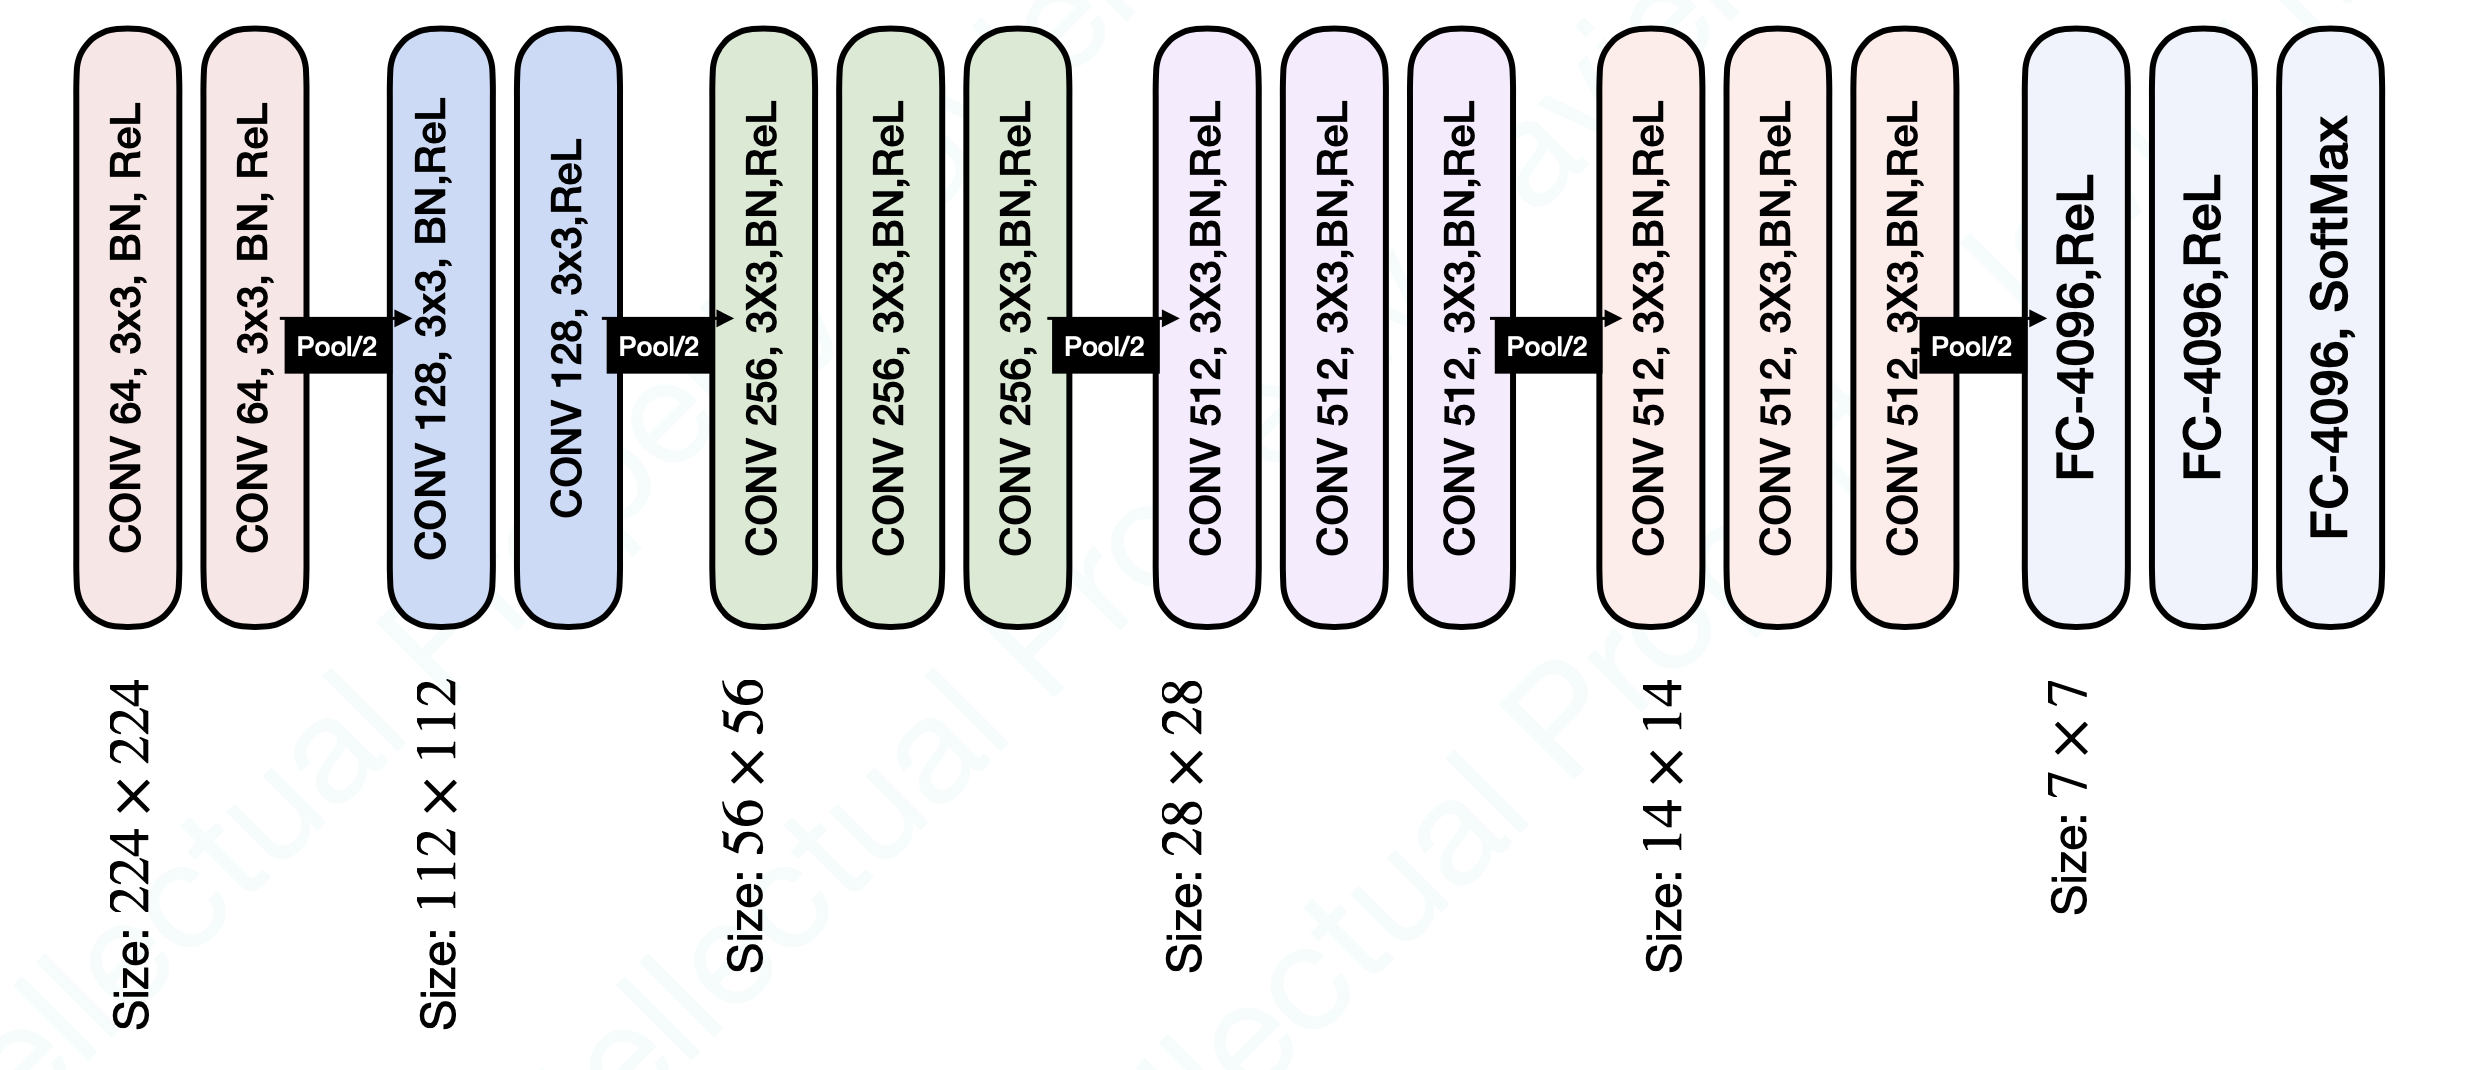

In [ ]:
# Load the VGG16 model and analyse the structure of this network
model = torchvision.models.vgg16(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 168MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Create a class named VGGNetFT (VGGNet Finetuned), which loads the pretrained model and re-trains its last layer.
class VGGNetFT(torch.nn.Module): # Defines a new class named VGGNetFT which inherits from torch.nn.Module.
  """
    Modified VGG model for fine-tuning.

    This class extends `torch.nn.Module` and encapsulates a modified VGG model with a customizable classifier
    suitable for fine-tuning on a specific classification task.

    Parameters:
        num_classes (int): The number of output classes for the classification task.
        finetune (bool): If True, freezes the parameters of the pre-trained VGG model during initialization.

    Attributes:
        num_classes (int): The number of output classes for the classification task.
        finetune (bool): Indicates whether the pre-trained VGG model parameters are frozen during initialization.
        model (torch.nn.Module): The pre-trained VGG model.
        classifier (torch.nn.Module): The classifier module added on top of the VGG model.
  """

  def __init__(self, num_classes, finetune=True):
      """
        Initializes the VGGNetFT model.

        Args:
            num_classes (int): The number of output classes for the classification task.
            finetune (bool): If True, freezes the parameters of the pre-trained ResNet model during initialization.
      """

      super(VGGNetFT, self).__init__()
      self.num_classes = num_classes
      self.finetune = finetune

      # Initializes a pre-trained VGG-16 model using models.vgg16(pretrained=True)
      self.model = ...

      if self.finetune:
        self.freeze()

      # Defines a classifier consisting of a sequential neural network module (nn.Sequential)
      # composed of two linear layers and a ReLU activation function. The input size of the
      # first linear layer is set to the number of features of the original
      # VGG model's fully connected layer (self.model.fc.in_features), and
      # the output size of the last linear layer is set to the number of classes (self.num_classes).
        # Modify the classifier architecture to match the input features of VGG16
      self.classifier = nn.Sequential(
          ...
      )

      self.model.classifier[-1] = self.classifier

  def freeze(self):
    """
      Freezes the parameters of the pre-trained ResNet model.

      This method sets the `requires_grad` attribute of all parameters of the pre-trained VGG model to False,
      effectively freezing the model's parameters.
    """
    for param in self.model.parameters():
        ...

  def forward(self, x):
      """
      Performs forward pass through the VGGNetFT model.

      Args:
          x (torch.Tensor): Input tensor to the model.

      Returns:
          logits (torch.Tensor): Raw logits or outputs of the model.
          probas (torch.Tensor): Probabilities computed from the logits using softmax activation.
      """
      logits = ...
      probas = ...
      return logits, probas

In [ ]:
def get_vgg16_ft(num_classes, finetune=True):
    """
    Helper function to instantiate a modified VGG16 model for fine-tuning.

    Parameters:
        num_classes (int): The number of output classes for the classification task.
        finetune (bool): If True, freezes the parameters of the pre-trained ResNet model.

    Returns:
        VGGNetFT: An instance of the modified VGG model configured for fine-tuning.
    """
    model = ...
    return model

In [ ]:
# Using the function get_vgg16_ft initialise the VGG16 FT model.
model = ...
model = ... # bring the model onto the respective hardware device: cpu/gpu

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
print(model)

VGGNetFT(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [ ]:
# Load the Resnet34 model and analyse the structure of this network
model = torchvision.models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.7MB/s]


In [ ]:
# Create a class named ResNetFT (ResNet Finetuned), which loads the pretrained model and re-trains its last layer.
class ResNetFT(torch.nn.Module): # Defines a new class named ResNetFT which inherits from torch.nn.Module.
  """
    Modified ResNet model for fine-tuning.

    This class extends `torch.nn.Module` and encapsulates a modified ResNet model with a customizable classifier
    suitable for fine-tuning on a specific classification task.

    Parameters:
        num_classes (int): The number of output classes for the classification task.
        finetune (bool): If True, freezes the parameters of the pre-trained ResNet model during initialization.

    Attributes:
        num_classes (int): The number of output classes for the classification task.
        finetune (bool): Indicates whether the pre-trained ResNet model parameters are frozen during initialization.
        model (torch.nn.Module): The pre-trained ResNet model.
        classifier (torch.nn.Module): The classifier module added on top of the ResNet model.
  """

  def __init__(self, num_classes, finetune=True):
      """
        Initializes the ResNetFT model.

        Args:
            num_classes (int): The number of output classes for the classification task.
            finetune (bool): If True, freezes the parameters of the pre-trained ResNet model during initialization.
      """

      super(ResNetFT, self).__init__()
      self.num_classes = num_classes
      self.finetune = finetune

      # Initializes a pre-trained ResNet-34 model using models.resnet34(pretrained=True)
      self.model = ...

      if self.finetune:
        self.freeze()

      # Defines a classifier consisting of a sequential neural network module (nn.Sequential)
      # composed of two linear layers and a ReLU activation function. The input size of the
      # first linear layer is set to the number of features of the original
      # ResNet model's fully connected layer (self.model.fc.in_features), and
      # the output size of the last linear layer is set to the number of classes (self.num_classes).
      self.classifier = nn.Sequential(
            ...
      )

      self.model.fc = self.classifier

  def freeze(self):
    """
      Freezes the parameters of the pre-trained ResNet model.

      This method sets the `requires_grad` attribute of all parameters of the pre-trained ResNet model to False,
      effectively freezing the model's parameters.
    """
    for param in self.model.parameters():
        ...

  def forward(self, x):
      """
      Performs forward pass through the ResNetFT model.

      Args:
          x (torch.Tensor): Input tensor to the model.

      Returns:
          logits (torch.Tensor): Raw logits or outputs of the model.
          probas (torch.Tensor): Probabilities computed from the logits using softmax activation.
      """
      logits = ...
      probas = ...
      return logits, probas

In [ ]:
def get_resnet_ft(num_classes, finetune=True):
    """
    Helper function to instantiate a modified ResNet model for fine-tuning.

    Parameters:
        num_classes (int): The number of output classes for the classification task.
        finetune (bool): If True, freezes the parameters of the pre-trained ResNet model.

    Returns:
        ResNetFT: An instance of the modified ResNet model configured for fine-tuning.
    """
    model = ...
    return model

In [ ]:
# Using the function get_resnet_ft initialise the VGG16 FT model.
model = ...
model = ... # bring the model onto the respective hardware device: cpu/gpu

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Using a pretrained VGG and ResNet model create an Ensemble Model, which fuses
# both architectures. You can add an additional FC layer on top after concatenating
# the corresponding feature vectors
class EnsembleModel(nn.Module):
    def __init__(self, ...):
        super(EnsembleModel, self).__init__()

        # Load pre-trained VGG model
        self.vgg = ...

        # Load pre-trained ResNet model
        self.resnet = ...

        # Fusion layer
        self.fusion = ...

    def forward(self, x):
        # Pass input through both models
        vgg_out = ...
        resnet_out = ...

        # Concatenate outputs
        combined_out = ...

        # Fusion
        fused_out = ...

        logits = ...
        probas = ...
        return logits, probas

### Loss function
Pytorch provides the
[torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
loss function that computes the softmax followed by the cross entropy.

Consider a 3-class problem. Let us take
an input, of true class y=1, being assigned the scores
$\hat{z} = [-100, 10, 8]$, i.e. the assigned probabilities being
$\hat{y} = [\frac{\exp(-100)}{\sum_i \exp(y_i)}, \frac{\exp(10)}{\sum_i \exp(y_i)}, \frac{\exp(8)}{\sum_i \exp(y_i)}] = [0.0000, 0.8808, 0.1192]$
the cross entropy loss is given by $-\sum_{i=0}^{3} \log(\hat{y}_y) = -\log(0.8808) \approx 0.1269$
and is computed in Pytorch as :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
# This prints :   torch.Tensor(0.1269)
```

In [ ]:
# instantiate the cross-entropy loss :
f_loss = ...

### Optimizer
In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which is one of the most common and stable optimizers. To know more about optimizers, there is a [compendium of optimizers
provided by Sebastian
Ruder](http://ruder.io/optimizing-gradient-descent/index.html).

Note that the optimizer needs a reference to the parameters that it needs
to modify.

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

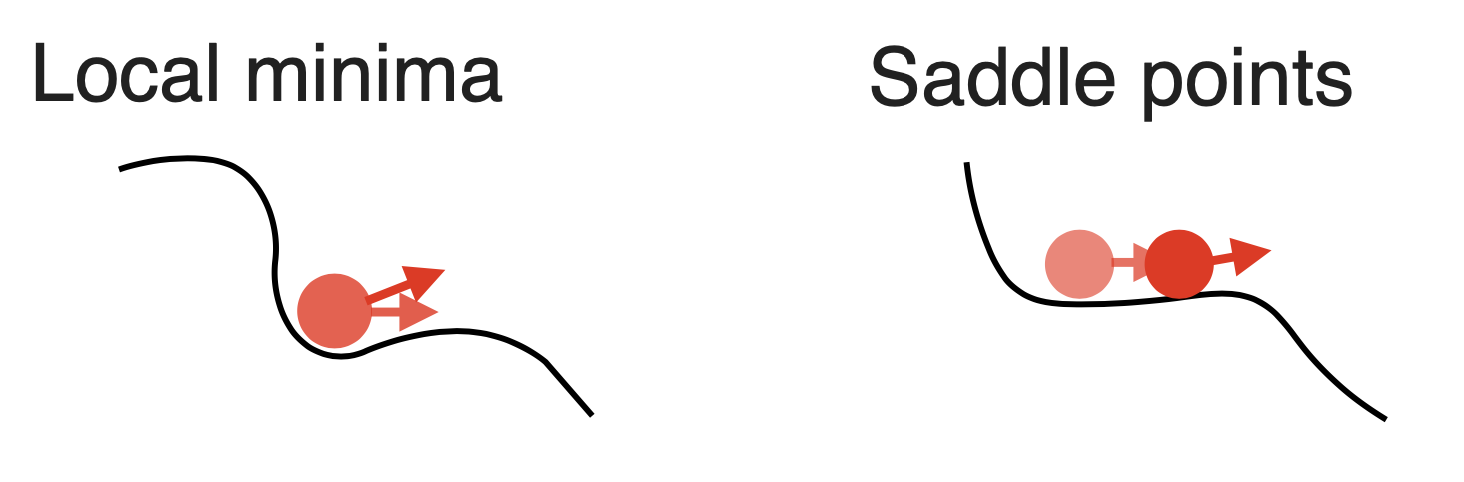

In [ ]:
optimizer = ...

### Scheduler

The learning rate scheduler adjusts the learning rate during training to optimize model performance by dynamically updating the learning rate based on predefined rules or metrics.


```
# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Decrease LR by a factor of 0.1 every 5 epochs

# Dummy training loop
for epoch in range(20):
    # Training Steps (Feedforward and Backpropagation)
    ...
    ...
    ...

    # Update the learning rate at the end of each epoch
    scheduler.step()

    # Print the current learning rate
    print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")
```

In [ ]:
scheduler = ...

## Model Training
Training a neural network involves iterating over the mini-batches of the training set and, for each mini-batch, computing the forward- and backward- propagations to provide the optimizer the gradient from which it can update the model parameters.


- Learning Process:
    1. Put inputs/labels into GPU device.
    2. Do forward propagation => Predictions
    3. Compute Loss function
    4. Do backward propagation => Gradients w.r.t. parameters
    5. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    6. REPEAT learning process

In [ ]:
def compute_accuracy_and_loss(model, data_loader, device):
    """
    Computes accuracy and average cross-entropy loss for a given model and data loader.

    This function iterates through the data loader, computes predictions using the provided model,
    and calculates accuracy and cross-entropy loss based on the model's predictions and ground truth labels.

    Args:
        model (torch.nn.Module): The model for which accuracy and loss are computed.
        data_loader (torch.utils.data.DataLoader): The data loader providing batches of data for evaluation.
        device (torch.device): The device (e.g., CPU or GPU) on which the model and data should be processed.

    Returns:
        accuracy (float): The accuracy of the model on the given data loader, in percentage.
        avg_loss (float): The average cross-entropy loss of the model on the given data loader.
        targets_arr (list): A list containing the ground truth labels for each batch.
        predictions_arr (list): A list containing the predicted labels for each batch.
    """

    correct_pred, num_examples = 0, 0

    cross_entropy = 0.

    predictions_arr = []
    targets_arr  = []

    for ii, (features, targets) in enumerate(data_loader):

        features = ... # bring the features x onto the hardware device
        targets = ... # bring the targets y onto the hardware device

        logits, probas = ... # feed-forward propagation z=logits, a=f(z)
        cross_entropy += ... # compute the cross-entropy loss on the logits and targets

        _, predicted_labels = ... # get y_hat=predicted_labels by having a look at the class likelihoods
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()
        targets_arr.append(targets)
        predictions_arr.append(predicted_labels)

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples, targets_arr, predictions_arr

In [ ]:
def train(model, num_epochs, train_loader, valid_loader, device):
    """
    Trains the given model using the provided data loaders for a specified number of epochs.

    This function iterates through the specified number of epochs, performing training steps on the training data,
    and evaluating the model on the validation data after each epoch. It tracks training and validation accuracy,
    loss, and additional metrics, and records the best model based on validation accuracy and loss.

    Args:
        model (torch.nn.Module): The model to be trained.
        num_epochs (int): The number of epochs for training.
        train_loader (torch.utils.data.DataLoader): The data loader providing batches of training data.
        valid_loader (torch.utils.data.DataLoader): The data loader providing batches of validation data.
        device (torch.device): The device (e.g., CPU or GPU) on which the model and data should be processed.

    Returns:
        None
    """

    minibatch_cost = []
    train_acc_lst, valid_acc_lst = [], []
    train_loss_lst, valid_loss_lst = [], []

    best_acc = 0
    best_loss = np.inf

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()

        for batch_idx, (features, targets) in enumerate(train_loader):

            # bring the training data (features, targets) onto the hardware device
            features = ...
            targets = ...

            # feed forward-propagation
            logits, probas = ...

            # compute cost function on the logits and targets
            cost = ...

            # clean gradients
            optimizer.zero_grad()

            # compute loss derivatives
            ...

            # append minibatch cost
            minibatch_cost.append(cost.item())

            # update model parameters
            optimizer.step() # w = w - learning_rate * partial_deriv_error

            # logging results
            if not batch_idx % 50:
                print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f'
                      %(epoch+1, num_epochs, batch_idx,
                        len(train_loader), cost))

        # call your scheduler here

        with torch.set_grad_enabled(False):
            train_acc, train_loss, train_targets, train_preds = ... # compute the accumulated loss and accuracy on the training dataset
            valid_acc, valid_loss, valid_targets, valid_preds = ... # compute the accumulated loss and accuracy on the valiadtion dataset

            print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                  epoch+1, num_epochs,
                  train_loss,
                  valid_loss,
                  train_acc,
                  valid_acc))

            train_acc_lst.append(train_acc)
            valid_acc_lst.append(valid_acc)
            train_loss_lst.append(train_loss)
            valid_loss_lst.append(valid_loss)

            if ... > ...: # check whether the accuracy has been improved
              ... = ...

              print('Better model: saving to disk.')
              state = {
                'model': model.state_dict(),
                'best_acc': best_acc,
                'epoch': epoch,
                'optimizer': optimizer.state_dict(),
              }
              if not os.path.isdir('checkpoint'):
                  os.mkdir('checkpoint')
              torch.save(state, './checkpoint/ckpt.pth')


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [ ]:
# Save trained model (example)
torch.save(model.state_dict(), '/content/gdrive/My Drive/teaching/jupyter/hslu/health/HS2024/models/vgg_model_ep5.pth')

In [ ]:
# Use the train() function to train the VGGNetFT model.
minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(..., ..., ..., ..., ...)

Epoch: 00001/00005 | Batch 00000/00653 | Cost: 1.4086
Epoch: 00001/00005 | Batch 00050/00653 | Cost: 0.9233
Epoch: 00001/00005 | Batch 00100/00653 | Cost: 0.8633
Epoch: 00001/00005 | Batch 00150/00653 | Cost: 0.8086
Epoch: 00001/00005 | Batch 00200/00653 | Cost: 0.8251
Epoch: 00001/00005 | Batch 00250/00653 | Cost: 0.7849
Epoch: 00001/00005 | Batch 00300/00653 | Cost: 0.7014
Epoch: 00001/00005 | Batch 00350/00653 | Cost: 0.7190
Epoch: 00001/00005 | Batch 00400/00653 | Cost: 0.7163
Epoch: 00001/00005 | Batch 00450/00653 | Cost: 0.6943
Epoch: 00001/00005 | Batch 00500/00653 | Cost: 0.7031
Epoch: 00001/00005 | Batch 00550/00653 | Cost: 0.5609
Epoch: 00001/00005 | Batch 00600/00653 | Cost: 0.6892
Epoch: 00001/00005 | Batch 00650/00653 | Cost: 0.6475
Epoch: 00001/00005 | Train cost: 0.0047 | Valid cost: 0.0148 | Train acc.: 77.4735% | Val.acc.: 81.2500%
Better model: saving to disk.
Time elapsed: 21.36 min
Epoch: 00002/00005 | Batch 00000/00653 | Cost: 0.5524
Epoch: 00002/00005 | Batch 0005

In [ ]:
# Move tensors from GPU to CPU and convert them to numpy arrays
train_acc_lst_cpu = [tensor.cpu().numpy() for tensor in train_acc_lst]
valid_acc_lst_cpu = [tensor.cpu().numpy() for tensor in valid_acc_lst]

In [ ]:
import matplotlib.pyplot as plt


def plot_curves(loss_lst, acc_lst, category='Training'):

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss values
    ax1.plot(loss_lst, label="{} Loss".format(category), color="tab:blue")
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('{} Loss'.format(category), fontsize=14, color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.grid(True)

    # Create a secondary y-axis for training accuracy
    ax2 = ax1.twinx()
    ax2.plot(acc_lst, label="{} Accuracy".format(category), color="tab:orange")
    ax2.set_ylabel('{} Accuracy'.format(category), fontsize=14, color="tab:orange")
    ax2.tick_params(axis='y', labelcolor="tab:orange")


    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower right')

    # Set title
    plt.title('{} Loss and Accuracy Over Epochs'.format(category), fontsize=16)

    plt.show()

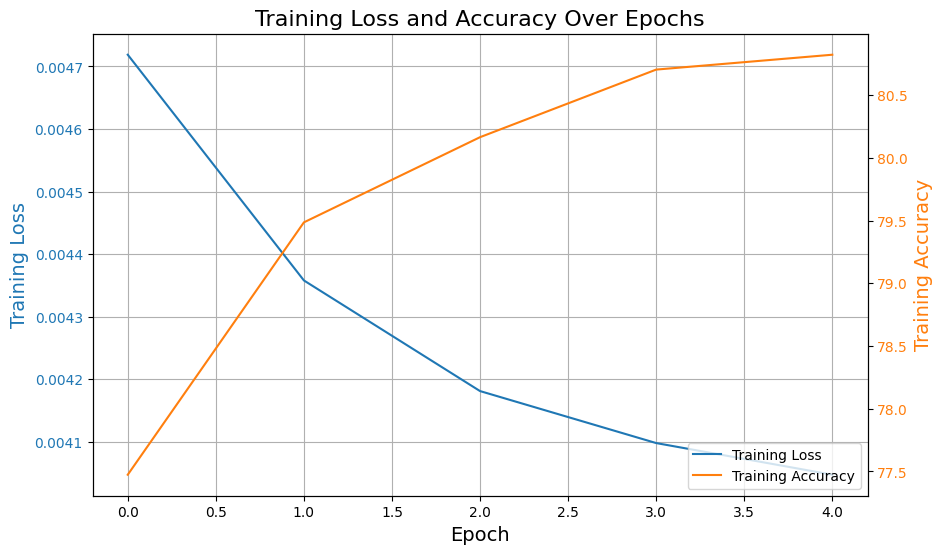

In [ ]:
# Use the plot_curves function to plot the loss and accuracy values on the training dataset
...

## Model Evaluation
Once you've trained your model, you're asked to

In [ ]:
# Using the compute_accuracy_and_loss function, evaluate the model on the test dataset
test_acc, test_loss, test_targets, test_preds = ...
print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 80.58%


In [ ]:
test_targets = torch.hstack(test_targets).cpu().detach().numpy()
test_preds = torch.hstack(test_preds).cpu().detach().numpy()

In [ ]:
print(test_targets.shape)
print(test_preds.shape)

(968,)
(968,)


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

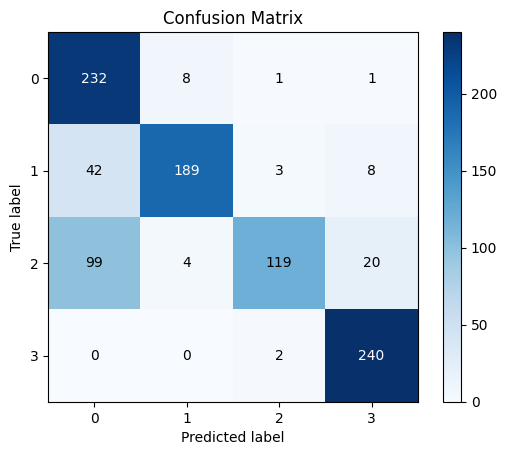

In [ ]:
from scikitplot.metrics import plot_confusion_matrix
# Using plot_confusion_matrix() plot the confusion matrix on the test dataset
...

In [ ]:
for ii in range(len(class_names)):
    correct = ((test_targets == ii)*1) * ((np.array(test_preds) == test_targets)*1)
    print('{}, {}: '.rjust(10).format(ii, class_names[ii]) + '{:.2f}%'.
          format(100*correct.sum()/test_targets[test_targets == ii].shape[0]))

  0, CNV: 95.87%
  1, DME: 78.10%
  2, DRUSEN: 49.17%
  3, NORMAL: 99.17%


In [ ]:
from sklearn.metrics import classification_report
# Use classification_report() to obtain statistics of the experimental results, such as precision, recall, f1-score
print(...)

              precision    recall  f1-score   support

         CNV       0.62      0.96      0.75       242
         DME       0.94      0.78      0.85       242
      DRUSEN       0.95      0.49      0.65       242
      NORMAL       0.89      0.99      0.94       242

    accuracy                           0.81       968
   macro avg       0.85      0.81      0.80       968
weighted avg       0.85      0.81      0.80       968



In [ ]:
# We have seen that the classification_report() gives us a summary of statistics on the test dataset.
# Now, it's your turn to implement them on the confusion matrix:
cm  = confusion_matrix(test_targets, test_preds)

fp = ... # compute the False Positives
fn = ... # compute the False Negatives
tp = ... # compute the True Positives
tn = ... # compute the True Negatives

accuracy = (np.array(test_preds) == np.array(test_targets)).sum() / len(test_preds)
precision = ... # compute the Precision
recall = ... # compute the Recall
f1 = ... # compute the F1-Score

recall = recall.astype(float)
precision = precision.astype(float)
f1 = f1.astype(float)

print("Accuracy of the model is: %.2f"% accuracy)
print('Recall of the model is: {}'.format(recall))
print('Precision of the model is: {}'.format(precision))
print('F1 score of the model is: {}'.format(f1))

Accuracy of the model is 0.81
Recall of the model is [0.95867769 0.78099174 0.49173554 0.99173554]
precision of the model is [0.62198391 0.94029851 0.952      0.89219331]
F1 score of the model is [0.75447154 0.85327314 0.64850136 0.93933464]


In [ ]:
# obtain one batch of test images
images, targets = next(iter(dataloaders['test']))

In [ ]:
len(images)

128

In [ ]:
# get sample outputs
logits, probas = model(images.to(DEVICE))

# convert output probabilities to predicted class
_, preds = torch.max(probas, 1)

ValueError: num must be an integer with 1 <= num <= 50, not 51

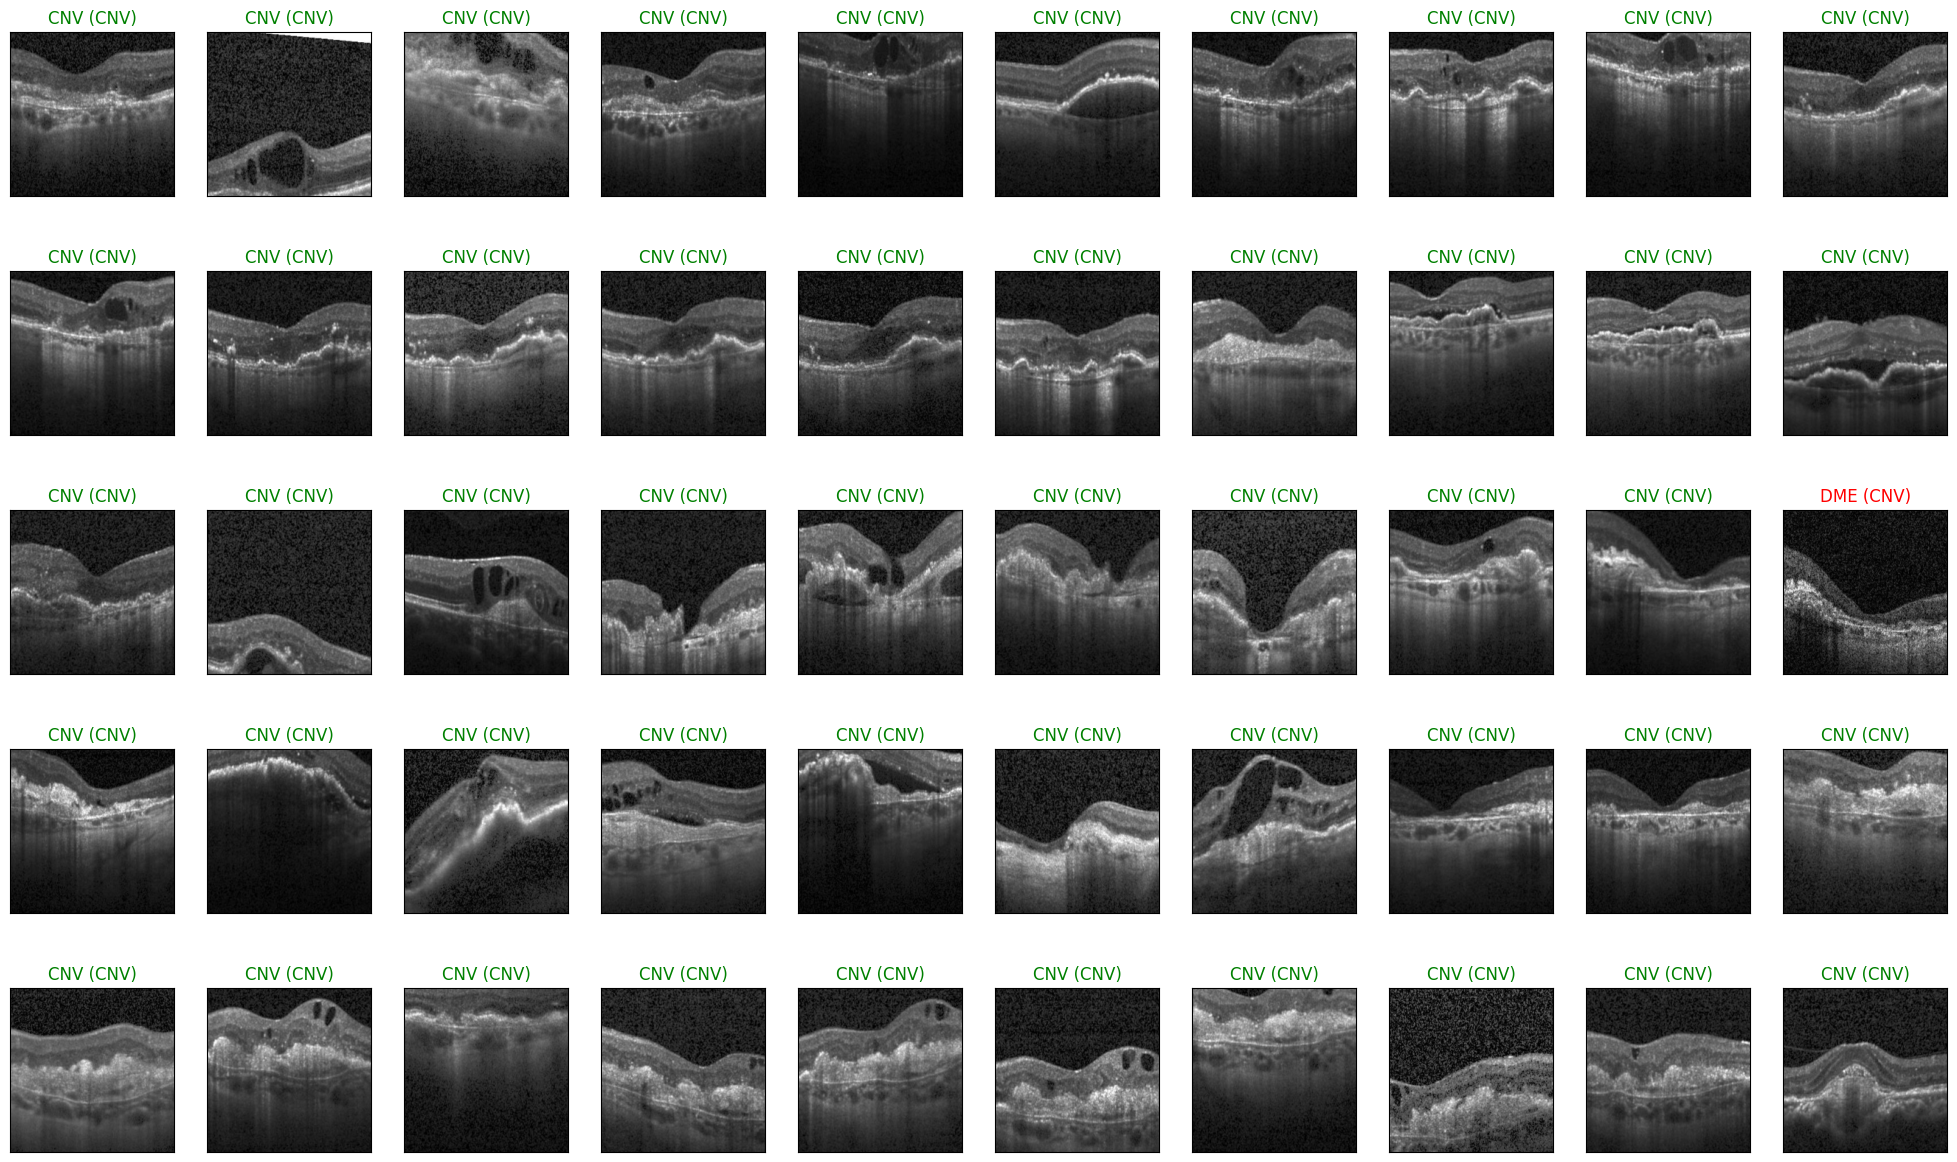

In [ ]:
num_imgs = min(50, len(images))

# Visualise some predicted images
fig = plt.figure(figsize=(25, 15))
for idx in np.arange(len(images)):
    if idx > num_imgs:
        break
    ax = fig.add_subplot(5, num_imgs//5, idx+1, xticks=[], yticks=[])
    curr_img = tensor2image(images[idx])
    plt.imshow(curr_img)
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[targets[idx]]),
                 color=("green" if preds[idx]==targets[idx].item() else "red"))

In [ ]:
def visualize_predictions(model, img, imglabel, figsize=(16, 5), class_names=None):
    """
    Visualizes the predictions made by the model on the input image.

    Args:
        model (torch.nn.Module): The trained model.
        img (torch.Tensor): The input image tensor.
        figsize (tuple): Figure size for visualization. Default is (16, 5).
    """
    # Transpose and convert to numpy array for visualization
    image_np = tensor2image(img)

    # Since we want to use the already pretrained weights to make some prediction
    # we are turning off the gradients
    with torch.no_grad():
        logits, _ = model(img.unsqueeze(0))
        # We take the softmax for probabilites since our outputs are logits
        probas = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
        print(probas)

        fig, (ax1, ax2) = plt.subplots(figsize=figsize, ncols=2)

        if class_names is not None:
          ax1.set_title('{}'.format(class_names[imglabel]))

        ax1.imshow(image_np)
        ax1.axis('off')
        ax2.barh(np.arange(len(probas)), probas.squeeze(), align='center', edgecolor='k', alpha=0.5)

        ax2.set_aspect(0.1)
        ax2.set_yticks(np.arange(len(probas)))
        ax2.set_yticklabels(np.arange(len(probas)))
        ax2.set_title('Class Probability')
        ax2.set_xlim(0, 1.1)

        if class_names:
            ax2.set_yticklabels(class_names)
        else:
            ax2.set_yticklabels(np.arange(len(probas)))

        plt.tight_layout()

In [ ]:
import random

# Use the function visualize_predictions() to display some predictions and evaluate the results.
# Are the predictions accurate enough?

idx = round(random.randint(0, len(images) - 1))
img = images[idx]
img = img.to(DEVICE)
print(img.shape)

imglabel = targets[idx]
imglabel = imglabel.detach().cpu().numpy().item()
print(imglabel)

torch.Size([3, 224, 224])
0


[0.813332   0.02846113 0.1547687  0.00343813]


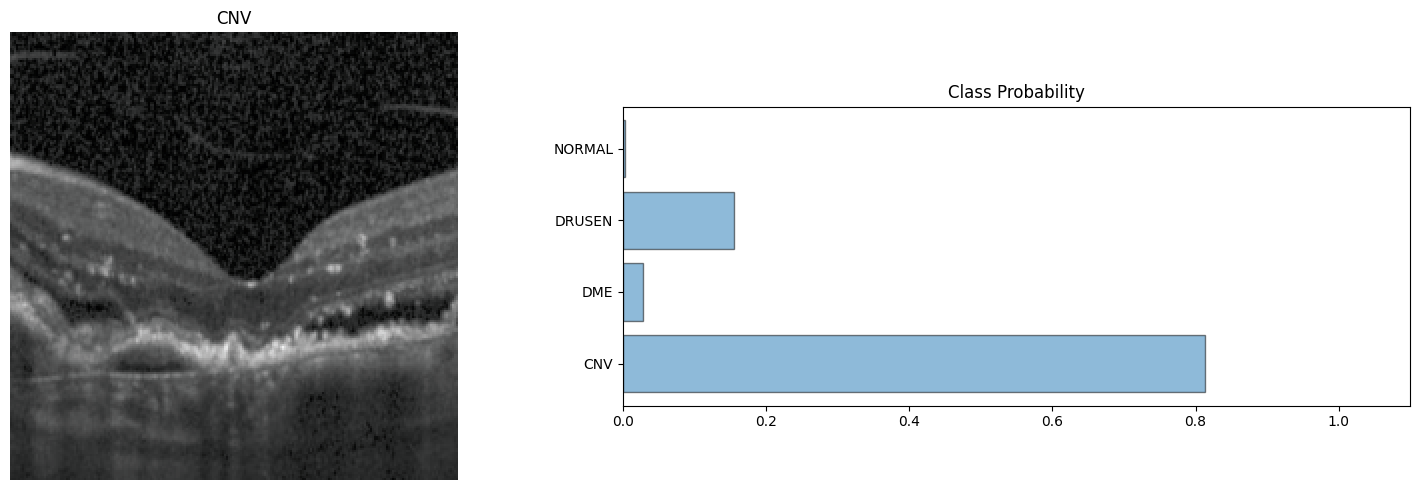

In [ ]:
class_names = image_datasets['train'].classes
visualize_predictions(model=model, img=img, imglabel=imglabel, class_names=class_names)

Study how the technique GradCam works and can be used for interpretability puroses. Use it to visualize the spatial regions on the images which contributed the most for the final predictions

In [ ]:
....

## Machine Learning Pipeline [BONUS]
Instead of fine-tune your CNN model, extract a Feature Vector and use  ML classifiers (e.g. Random Forest, XGBoost ) to classify the images based on the extracted features. Compare their results and also against the statistics extracted from the transfer-learning approach.
A Figure explaining the ML Pipeline is given below.
Hint: use the sklearn library to train your different classifiers, e.g. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [XGBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). For hyperparameter tuning, use sklearn [grid-search](https://scikit-learn.org/stable/modules/grid_search.html). In this approach, you feed the batches onto your pre-trained CNN models (feed-forward propagation). You can collect these vectors and use them as training inputs for your ML models.

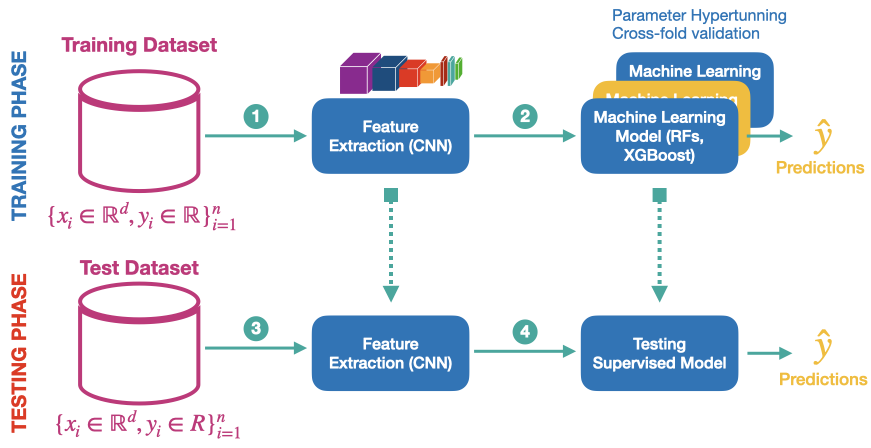

# Summary and Findings

In this final section, you will have the chance to reflect on your findings. You are asked to summarize observations and provide insights into the model's performance fosters a deeper understanding of the results.
Fill in the given notebook after each mentioned point your main take-home learning.

### Observations and Insights:

1. **Model Accuracy:**
   - Reflect on the overall accuracy achieved by the model on the test set. Consider whether the accuracy aligns with expectations?

Your answer: ...

2. **Loss Curves:**
   - Analyze the loss curves plotted during training and validation. Look for patterns such as convergence, fluctuations, or signs of overfitting. Consider how well the model generalizes to unseen data?

Your answer: ...

3. **Class Predictions:**
   - Examine the class predictions made by the model on the test images. Identify instances where the model performed well and cases where predictions may be challenging.

Your answer: ...


### Interpretation and Thoughts:

1. **Strengths and Limitations:**
   - Identify the strengths of the trained model, such as its ability to generalize to new data or handle specific patterns. Additionally, discuss any limitations or challenges encountered during the training process?

**Your answer:** ...


2. **Possible Improvements:**
   - Suggest potential improvements or modifications that could enhance the model's performance. This may include adjustments to hyperparameters, exploring different architectures, or incorporating additional data.

**Your answer:** ...

3. **Future Work:**
   - Discuss possible directions for future work based on the project's outcomes. This could involve expanding the dataset, exploring advanced techniques, or addressing specific challenges observed during model evaluation.

**Your answer:** ...

### Conclusion:

Consolidate your insights, draw conclusions from your experiments, and critically assess the developed transfer learning model for OCT diagnosis on retina images. What are the major take-home messages from this project?

**Your answer:** ...